### Halo Formation
***
In this tutorial we will learn how to implement a simple model for identifying collapsed dark-matter objects i.e halos.

Identifying collapsed structures is an important task for any simulation of large-scale structure since this is where star formation will take place. A direct approach involves measuring the non-linear density to high resolution within an N-body simulation. However this requires a large amount of computational resources, and we often require a model which can produce populations of collapsed halos without running a simulation.

Bond et al (1991) devised a model expanding on Press & Schechter (1976) which predicts the distribution of collapsed structures based entirely on the initial conditions of the universe. This initial density field is smoothed sucessively from large to small scales and halos are placed wherever the smoothed density field first exceeds a "Barrier", defined by spherical collapse models.

### Begin Initialisation

In [1]:
### This is for google collab or any machine that has not installed 21cmFAST yet

# !sudo apt-get install libfftw3-dev libgsl-dev
# %pip install pip --upgrade
# %pip install 21cmFAST==4.0.0b0

In [2]:
#load in some functions we will use to calculate the random walks
import py21cmfast as p21c
from py21cmfast.wrapper.cfuncs import evaluate_sigma, get_growth_factor, return_uhmf_value, return_chmf_value
from py21cmfast import InputParameters
default_p21c_inputs = InputParameters(random_seed=1)

import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
""" This cell contains utility functions to plot and set up the random walks. You are not expected
to modify these functions during the tutorial. Feel free to collapse the cell"""

def setup_walk_steps(
    *,
    start_sigma: float | None = None,
    start_mass: float | None = None,
    min_mass: float = 1e8,
    max_mass: float = 1e16,
    num_steps: int = 100,
):
    """Set up the steps for the random walk."""
    if (start_sigma is None and start_mass is None) or (start_sigma is not None and start_mass is not None):
        raise ValueError("Exactly one of start_sigma or start_mass must be provided.")
    start_sigma_val = M_to_sigma(start_mass) if start_mass is not None else start_sigma
    start_mass_val = sigma_to_M(start_sigma) if start_sigma is not None else start_mass
    mass_steps = np.logspace(np.log10(max_mass), np.log10(min_mass), num_steps)
    mass_steps = mass_steps[mass_steps < start_mass_val]
    sigma_steps = M_to_sigma(mass_steps)
    sigma_steps = np.concatenate(([start_sigma_val],sigma_steps))
    mass_steps = np.concatenate(([start_mass_val],mass_steps))
    return sigma_steps, mass_steps

from scipy.optimize import root_scalar
def sigma_to_M(sigma: np.ndarray | float) -> np.ndarray:
    """ Convert sigma values to mass values using root finding. """
    if isinstance(sigma, float):
        sigma = np.array([sigma])
    result = np.zeros_like(sigma)
    for i,sig in enumerate(sigma):
        if sig <= 0:
            result[i] = np.inf
            continue
        func = lambda x: M_to_sigma(x) - sig
        sol = root_scalar(func,bracket=(1e7, 1e20))
        if not sol.converged:
            raise ValueError("Root finding did not converge.")
        result[i] = sol.root
    return result.squeeze()

def M_to_sigma(M: np.ndarray | float) -> np.ndarray | float:
    """ Convert mass values to sigma values using 21cmfast. """
    if isinstance(M, float):
        M = np.array([M])
    
    sigma, _ = evaluate_sigma(inputs=default_p21c_inputs, masses=M)
    return sigma.squeeze()


from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
def plot_walks(
        *,
        redshift: float,
        walks: np.ndarray,
        sigma_steps: np.ndarray,
        mass_steps: np.ndarray,
        delta: float = 0.0,
        halo_sigma: np.ndarray = None,
        halo_masses: np.ndarray = None,
        barrier: np.ndarray = None,
        output_file: str = None,
        hmf_type: str = 'PS',
        n_walks_plot: int = 10,
        fig: plt.Figure | None = None,
        ax: plt.Axes | None = None,
        color: str | None = None,
        label: str = "Random Walks",
        seed: int = 12345,
        plot_crossings: bool = False,
):
    """ Plot the random walks and the barrier. """

    n_rows = 1 + (1 if halo_sigma is not None else 0) + (1 if halo_masses is not None else 0)
    height_ratios = [2.5,]
    fig_height = 4
    if halo_sigma is not None:
        height_ratios.insert(0,1)
        fig_height += 2
    if halo_masses is not None:
        height_ratios.append(1)
        fig_height += 2

    first_plot = (fig is None)
    if first_plot:
        fig, ax = plt.subplots(nrows=n_rows,ncols=1,figsize=(6,fig_height),layout='constrained',height_ratios=height_ratios)
        ax = np.atleast_1d(ax)
        fig.get_layout_engine().set(w_pad=2 / 72, h_pad=2 / 72, hspace=0.0, wspace=0.0)

    walk_color = color if color is not None else 'r'
    line_color = color if color is not None else 'k'
    
    walk_ax = ax[(1 if halo_sigma is not None else 0)]

    #select random walks to plot
    rng = np.random.default_rng(seed=seed)
    sel = rng.choice(walks.shape[0], n_walks_plot, replace=False)

    #plot the random walks
    if barrier is not None and first_plot:
        walk_ax.plot(sigma_steps, barrier, color='k', linestyle='--', linewidth=2.5, label=f"{hmf_type} Barrier")
        
    walk_ax.plot(sigma_steps, walks[sel,:].T, color=walk_color, alpha=0.5, label=label)
    walk_ax.set_xlabel(r"$\sigma (M)$")
    walk_ax.set_ylabel(r"$\delta$")
    walk_ax.set_ylim(min(-1,delta-0.2),10)

    handles, labels = walk_ax.get_legend_handles_labels()
    labels,id = np.unique(labels, return_index=True)
    handles = [handles[i] for i in id]
    labels = [str(l) for l in labels]
    walk_ax.legend(loc='upper left', handles=handles, labels=labels, fontsize=8)
    if halo_sigma is not None and plot_crossings:
        crossings = np.argwhere(sigma_steps[None,None,:]==halo_sigma[sel,:,None]) #(walk,z,step)
        walk_ax.scatter(halo_sigma[sel][crossings[:,0]], barrier[crossings[:,-1]], color=walk_color, marker='x', s=50)

    #plot the sigma distribution
    if halo_sigma is not None:
        sigma_ax = ax[0]
        sigma_ax.sharex(walk_ax)
        #makes sure the values are not on the edges
        sigma_bins = np.concatenate(
            (
                sigma_steps[0:1] - np.diff(sigma_steps)[0]/2,
                sigma_steps[1:] - np.diff(sigma_steps)/2,
                sigma_steps[-2:-1] + np.diff(sigma_steps)[-1]/2
            )
        )
        sigma_hist,_ = np.histogram(
            halo_sigma,
            bins=sigma_bins,
        )
        sigma_hist = sigma_hist / np.sum(halo_sigma > 0)
        
        sigma_ax.step(sigma_steps, sigma_hist, color=line_color, linestyle='-', label="Sigma", linewidth=2.5)
        if plot_crossings:
            [sigma_ax.axvline(halo_sigma[s],color=walk_color) for s in sel]
        sigma_ax.tick_params(bottom=False,labelbottom=False)
        sigma_ax.set_ylabel("Fraction of Crossings")

    #plot the mass distribution
    if halo_masses is not None:
        inputs = default_p21c_inputs.evolve_input_structs(HMF=hmf_type)
        mass_dens = (
            inputs.cosmo_params.cosmo.critical_density(0).to("M_sun Mpc^-3").value
            * inputs.cosmo_params.cosmo.Om0
        )

        mass_ax = ax[(2 if halo_sigma is not None else 1)]
        #define bins to each contain one step increasing in mass
        mass_bins = np.concatenate(
            (
                mass_steps[0:1] - np.diff(mass_steps)[0]/2,
                mass_steps[1:] - np.diff(mass_steps)/2,
                mass_steps[-2:-1] + np.diff(mass_steps)[-1]/2
            )
        )
        dlnm = np.concatenate(
            (np.log(mass_bins[:-1]) - np.log(mass_bins[1:]),)
        )
        hm_hist,_ = np.histogram(
            halo_masses,
            bins=mass_bins[::-1],
        )
        hm_hist = hm_hist[::-1] #reverse to be in decreasing mass order
        # for step in mass_steps:
        #     print()
        dndlnm_fac = (
            (1 / walks.shape[0]) * #N_walk(M) --> F_mass(M)
            mass_dens * #F_mass(M) --> rho(M)
            (1/mass_steps) * #rho(M) --> n(M)
            (1/dlnm) #n(M) --> dn/dlnM
        )
        hm_hist = hm_hist * dndlnm_fac
        one_halo = dndlnm_fac # one halo in each bin
        
        if sigma_steps[0] == 0.0 and delta == 0.0:
            hmf = return_uhmf_value(
                mass_values=mass_steps[1:],
                redshift=redshift,
                inputs=inputs,
            ) * mass_dens
        else:
            hmf = return_chmf_value(
                mass_values=mass_steps[1:],
                redshift=redshift,
                inputs=inputs,
                delta_values=np.array([delta]),
                condmass_values=np.array([mass_steps[0]]),
            ).squeeze() * mass_dens
        
        hmf = np.concatenate(([0],hmf)) #add zero at high mass end where no halos possible

        #although the mass bins contain the steps, the masses are exactly at the steps
        mass_ax.step(mass_steps, hm_hist, color=line_color, linestyle='-', label="Halo Mass", linewidth=2.5)
        mass_ax.plot(mass_steps, hmf, color=line_color, linestyle=':', label=hmf_type+' HMF')
        mass_ax.set_xscale('log')
        mass_ax.set_yscale('log')
        mass_ax.set_ylim(1e-7,1e1)
        mass_ax.set_xlim(1e8,2e13)
        mass_ax.set_ylabel("dn/dlnM [Mpc-3]")
        mass_ax.set_xlabel("Mass [M_sun]")
        if plot_crossings:
            [mass_ax.axvline(halo_masses[s],color=walk_color) for s in sel]
        #do this on first plot only
        if first_plot:
            mass_ax.plot(mass_steps, one_halo,color='k',linestyle='--',label='sampling limit')
            l_handles = [Line2D([0], [0], color='k', linestyle='-', label='Halo Mass'),
                        Line2D([0], [0], color='k', linestyle=':', label=hmf_type+' HMF'),
                        Line2D([0], [0], color='k', linestyle='--', label='Sampling Limit')]
            mass_ax.legend(loc='lower left', handles=l_handles, fontsize=8)

    if output_file:
        plt.savefig(output_file)
    return fig,ax

In [4]:
#set up parameters for the random walks
redshift = 5.0

growthf = np.array([get_growth_factor(redshift=redshift, inputs=default_p21c_inputs)])

#set up limits / steps for the mass range we want to sample
min_mass = 1e8 #solar masses
max_mass = 1e16
num_steps = 100 #number of log-spaced steps in mass for the random walks

#this functions simply sets up a range of sigma values corresponding to the mass range we want to sample
sigma_steps,mass_steps = setup_walk_steps(start_sigma=0.0,
                                             min_mass=min_mass,
                                             max_mass=max_mass,
                                             num_steps=num_steps)

#number of walks total
n_walks = 100000

### End Initialisation
***

### Random Walks
This model relies on the assumption that our initial conditions are a Gaussian random field (see tutorial `00-ics`). Since each mode in the random field was sampled independently, if we were to apply low-pass filters by successively removing high-frequency modes from our field, the value of the density field as a function of the filter scale will form a random walk, where the jump in overdensity at each scale is uncorrelated

$\delta_{n+1} = \delta_n + N(0,\sqrt{\sigma_{n+1}^2 - \sigma_{n}^2})$.

Your first task is to create a fucntion `my_random_walk` which implements the above process in Python, producing a number `n_walks` of random walk realisations, given a series of standard deviations `sigma_steps` and a starting overdensity `start_delta`.

In [ ]:

def my_random_walk(sigma_steps, n_walks, start_delta=0., seed=42):
    """
    Calculate the steps for the sharp-k filtered random walk.
    """
    rng = np.random.default_rng(seed)
    start_points = np.full((n_walks, 1), start_delta)
    steps = np.concatenate(
        (
            start_points, #starting point
            rng.normal(
                loc=0.,
                scale=np.sqrt(np.diff(sigma_steps**2)),
                size=(n_walks, len(sigma_steps)-1),
            ),
        ),
        axis=1,
    )
    return np.cumsum(steps,axis=1)

#do the walks
walks = my_random_walk(sigma_steps,n_walks)

Now that the random walks are done, we will visualise them on their own

(<Figure size 600x400 with 1 Axes>,
 array([<Axes: xlabel='$\\sigma (M)$', ylabel='$\\delta$'>], dtype=object))

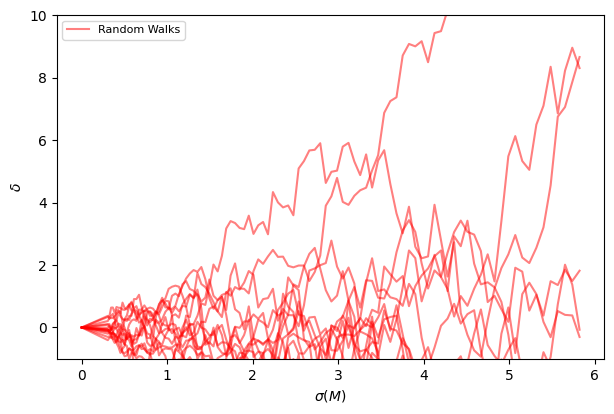

In [6]:
plot_walks(
    redshift=redshift,
    walks=walks,
    mass_steps=mass_steps,
    sigma_steps=sigma_steps,
    n_walks_plot=15,
)

### Barrier Crossing
Now that our random walks are set, we define a barrier for halo formation. Spherical collapse models give a value for this barrier which is fairly robust to choices of cosmology or redshift $\delta \times D(z) > 1.686$, where D(z) is the linear growth factor.

Your next task is to create two functions: The first of which calculates the value of the barrier at each scale and redshift provided. The second function should be given a series of random walks (shape `[n_walks, sigma_steps]`) and a barrier (shape `[sigma_steps, redshifts]`) and return the sigmas and masses where the walks **FIRST** cross the given barrier.

In [7]:
def my_barrier_PS(sigma_steps, growthf):
    """ Write a function to compute the Press-Schechter barrier here.
    
    In general, this can be a function of both sigma and redshift/growth factor."""
    return np.full((sigma_steps.shape[0],growthf.shape[0]),1.686)/growthf[None,:]

#Set up the Barrier
barrier_steps = my_barrier_PS(sigma_steps, growthf)

def my_crossing_points(delta_arr, barrier, sigma_arr, mass_arr):
    """ Write a function to compute the crossing points here. given an array of random walks and a barrier."""
    halo_bool = np.any(delta_arr[:,:,None] > barrier[None,:,:], axis=1)
    crossing_points = np.where(
        halo_bool,
        np.argmax(delta_arr[:,:,None] > barrier[None,:,:], axis=1),
        -1,
    )
    
    halo_masses = np.where(crossing_points==-1,np.nan,mass_arr[crossing_points])
    halo_sigma = np.where(crossing_points==-1,np.nan,sigma_arr[crossing_points])
    return halo_masses, halo_sigma, crossing_points

#find at which indices the random walks cross the barrier
halo_masses, halo_sigma, crossing_points = my_crossing_points(
    delta_arr=walks,
    barrier=barrier_steps,
    sigma_arr=sigma_steps,
    mass_arr=mass_steps,
)

Now we plot the random walks with their barrier crossing, which determines the population of halos masses

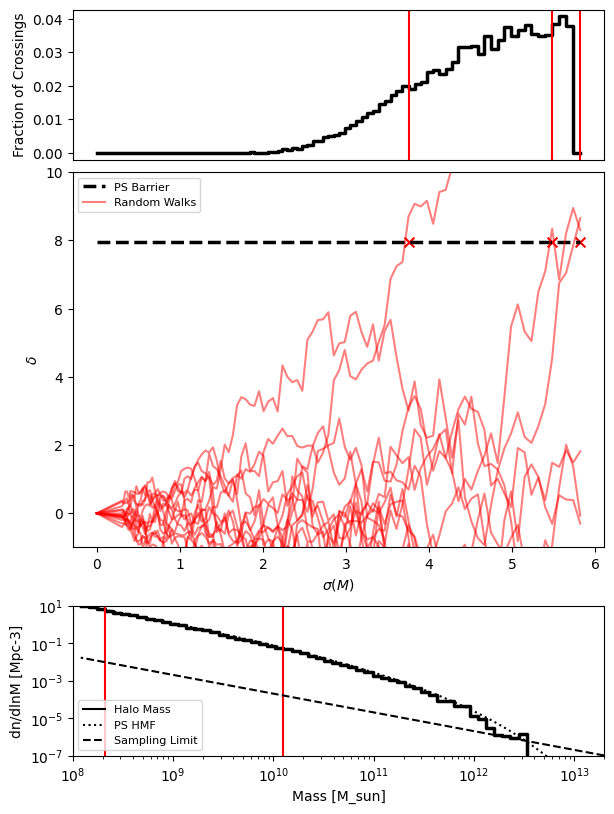

In [ ]:
_ = plot_walks(
    walks=walks,
    redshift=redshift,
    mass_steps=mass_steps,
    sigma_steps=sigma_steps,
    barrier=barrier_steps,
    halo_masses=halo_masses,
    halo_sigma=halo_sigma,
    n_walks_plot=15, #change this to plot more or less walks
    hmf_type='PS', #This plots an expected result 21cmFAST mass functions
    plot_crossings=True,
)

Here red vertical lines show the mass/sigma of the randomly selected walks which cross the barrier at some point, and the dotted line in the bottom panel shows the expected Press-Schecter collapsed mass fraction.

### A Different Barrier
Of course, the Universe does not always hold to spherical symmetry. This results in the above barrier underpredicting the number of large halos at high redshift. An improvement to this barrier was suggested by Sheth & Tormen (2001), who considered elliptical collapse modes in their barrier function.

$B_{ST}(\sigma,z) = \sqrt{a} \frac{1.686}{D(z)} ( 1 + b (\frac{1}{a}(\frac{1.686}{D(z)\sigma})^2)^{-c})$

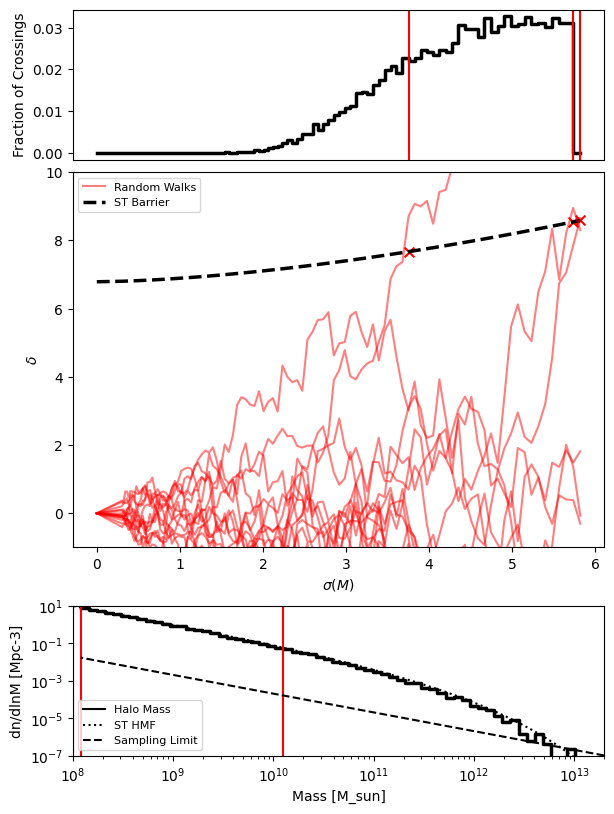

In [ ]:
def my_barrier_ST(sigma, growthf, a = 0.73, b = 0.34, c = 0.81):
    """ Write a function to compute the Sheth-Tormen barrier here.
    Note that you can change the parameters of the mass function to achieve different results.
    """
    delta = 1.686 / growthf[None,:]
    return np.sqrt(a) * delta * (
        1. + b * pow(sigma[:,None] * sigma[:,None] /
        (a * delta * delta), c)
    )

#Set up the Barrier
barrier_steps_ST = my_barrier_ST(sigma_steps, growthf)

halo_masses_ST, halo_sigma_ST, crossing_points_ST = my_crossing_points(
    delta_arr=walks,
    barrier=barrier_steps_ST,
    sigma_arr=sigma_steps,
    mass_arr=mass_steps,
)

_ = fig, ax = plot_walks(
    walks=walks,
    redshift=redshift,
    mass_steps=mass_steps,
    sigma_steps=sigma_steps,
    barrier=barrier_steps_ST,
    halo_masses=halo_masses_ST,
    halo_sigma=halo_sigma_ST,
    n_walks_plot=15, #change this to plot more or less walks
    hmf_type='ST',  #This plots an expected result 21cmFAST mass functions
    plot_crossings=True
)

### Conditioning
The mass functions we have made so far deal with the entire universe, i.e. a region at mean density (`delta == 0`) and effectively infinite size (`sigma == 0`). But this is not necessarily required. We can calculate the expected halo mass distribution in a region of any size and density simply by starting the random walks at that location in the `delta`-`sigma` diagram.

In [ ]:
# This cell performs random walks at a few different conditions
# NOTE: You can modify these starting masses and deltas to see how the halo mass function changes
sigma_12, mass_12 = setup_walk_steps(start_mass=1e12,
                                        min_mass=min_mass,
                                        max_mass=max_mass,
                                        num_steps=num_steps)
sigma_15, mass_15 = setup_walk_steps(start_mass=1e15,
                                        min_mass=min_mass,
                                        max_mass=max_mass,
                                        num_steps=num_steps)
walks_overdense_12 =  my_random_walk(sigma_12, n_walks=n_walks, start_delta=1./growthf)
walks_underdense_15 = my_random_walk(sigma_15, n_walks=n_walks, start_delta=-0.5/growthf)

#find at which indices the random walks cross the barrier
barrier_steps_ST_12 = my_barrier_ST(sigma_12, growthf)
barrier_steps_ST_15 = my_barrier_ST(sigma_15, growthf)
halo_masses_ST_o_12, halo_sigma_ST_o_12, crossing_points_ST_o_12 = my_crossing_points(
    delta_arr=walks_overdense_12,
    barrier=barrier_steps_ST_12,
    sigma_arr=sigma_12,
    mass_arr=mass_12,
)
halo_masses_ST_u_15, halo_sigma_ST_u_15, crossing_points_ST_u_15 = my_crossing_points(
    delta_arr=walks_underdense_15,
    barrier=barrier_steps_ST_15,
    sigma_arr=sigma_15,
    mass_arr=mass_15,
)

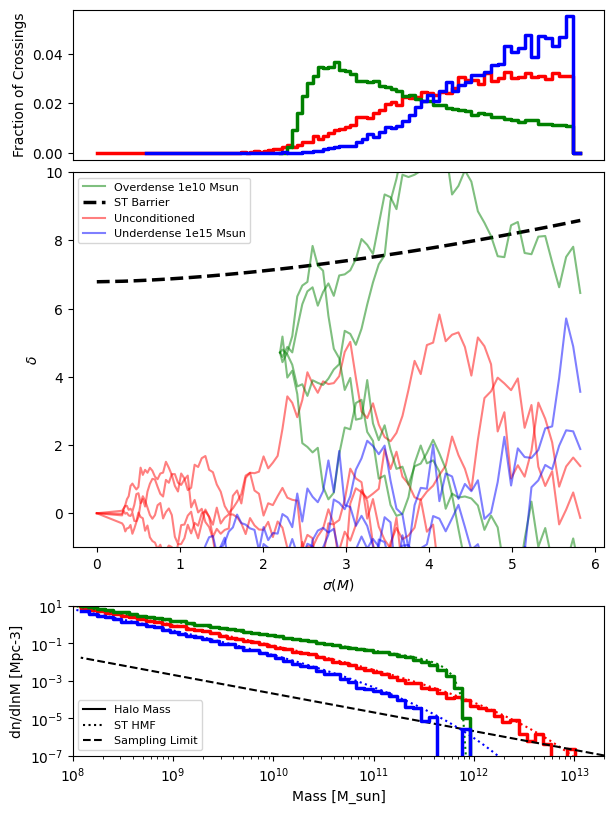

In [11]:
#now plot all three cases together
fig, ax = plot_walks(
    walks=walks,
    redshift=redshift,
    mass_steps=mass_steps,
    sigma_steps=sigma_steps,
    barrier=barrier_steps_ST,
    halo_masses=halo_masses_ST,
    halo_sigma=halo_sigma_ST,
    n_walks_plot=4,
    color='r',
    delta=0.0,
    hmf_type='ST',
    label='Unconditioned'
)
fig, ax = plot_walks(
    fig=fig,
    ax=ax,
    walks=walks_overdense_12,
    redshift=redshift,
    mass_steps=mass_12,
    sigma_steps=sigma_12,
    barrier=barrier_steps_ST_12,
    halo_masses=halo_masses_ST_o_12,
    halo_sigma=halo_sigma_ST_o_12,
    n_walks_plot=4,
    color='g',
    delta=1.0,
    hmf_type='ST',
    label='Overdense 1e10 Msun'
)
fig, ax = plot_walks(
    fig=fig,
    ax=ax,
    walks=walks_underdense_15,
    redshift=redshift,
    mass_steps=mass_15,
    sigma_steps=sigma_15,
    barrier=barrier_steps_ST_15,
    halo_masses=halo_masses_ST_u_15,
    halo_sigma=halo_sigma_ST_u_15,
    n_walks_plot=4,
    color='b',
    delta=-0.5,
    hmf_type='ST',
    label='Underdense 1e15 Msun'
)

It should be clear that random walks which start at higher density have a higher proportion of their crossing points near the starting mass, and since the walks go from high to low mass, starting the random walk at lower masses removes the possibility of crossing at the highest mass scales.

### Simulated Halo Catalogs

When we want create a cosmological simulation, we first define the initial conditions on a Gaussian random field with the same power spectrum used to define our sigma in the random walks, meaning each cell is a sample of a random walk starting at `sigma==delta==0`. As a result, if we condition our random walks on the density and size of each cell in an initial conditions field, the sum of our crossing points *should* converge to those resulting from unconditioned random walks. To speed things up we will use `21cmFAST` for this, which does not explicity perform the random walks, but samples from their resulting HMFs.

Number of halos: 1088959


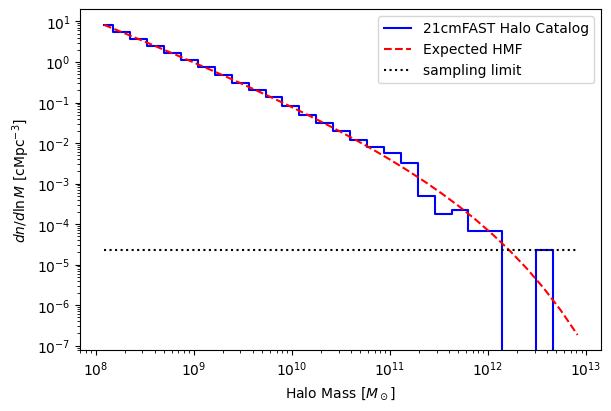

In [12]:
inputs = p21c.InputParameters.from_template(["latest-dhalos","size-tiny"],random_seed=1234)
box_volume = inputs.simulation_options.BOX_LEN**3 #cMpc^3
cell_size = inputs.simulation_options.cell_size #cMpc
cell_volume = cell_size**3 #cMpc^3
mass_density = inputs.cosmo_params.cosmo.critical_density(0).to('Msun/Mpc^3').value * inputs.cosmo_params.OMm #Msun/cMpc^3

#Here we comput the initial conditions grid
ics = p21c.compute_initial_conditions(inputs=inputs)

#Here we take each cell of the initial conditions and sample from its conditional mass function, as seen above
halos = p21c.determine_halo_list(redshift=redshift, initial_conditions=ics, inputs=inputs)
print(f"Number of halos: {halos.get('n_halos')}")

#set up bins for the mass function
hm_bins = np.logspace(8,13,30)
dlnm = np.log(hm_bins[1:]) - np.log(hm_bins[:-1])
bin_centres = (hm_bins[:-1] * np.exp(dlnm/2))

fig, ax = plt.subplots(1,1,figsize=(6,4),layout='constrained')
halo_hist, _ = np.histogram(halos.get('halo_masses'), bins=hm_bins)
catalog_hmf = halo_hist / dlnm / box_volume

#This is a utility in 21cmFAST which computes the expected unconditional HMF given the inputs.
#In this case it will return the Sheth-Tormen HMF, which is what 21cmFAST uses by default.
expected_hmf = p21c.wrapper.cfuncs.return_uhmf_value(
                mass_values=bin_centres,
                redshift=redshift,
                inputs=inputs,
            ) * mass_density

#Plotting
ax.step(bin_centres, catalog_hmf, where='mid', label='21cmFAST Halo Catalog', color='b')
ax.plot(bin_centres, expected_hmf, label='Expected HMF', color='r', linestyle='--')
ax.plot(bin_centres, 1/box_volume/dlnm, label='sampling limit', color='k', linestyle=':')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Halo Mass [$M_\odot$]')
ax.set_ylabel(r'$dn/d\ln M$ [cMpc$^{-3}$]')
_ = ax.legend()